In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('../data/properties.csv')

In [325]:
# Count the number of unique localities
num_unique_localities = df['locality'].nunique()
num_unique_zipcode = df['zip_code'].nunique()

print("Number of unique localities:", num_unique_localities)
print("Number of unique zip codes:", num_unique_zipcode)

Number of unique localities: 44
Number of unique zip codes: 1076


In [326]:
# Define features and target variable
X = df.drop(columns=['id', 'region', 'cadastral_income', 'price'])  # Features
y = df['price']  # Target variable

# New Feature: Extract the first two digits of the zip_code 
X['zip_code'] = X['zip_code'].astype(str)
X['postal_zone'] = X['zip_code'].str[:2]

num_unique_postalzone = X['postal_zone'].nunique()
print("Number of unique postal codes:", num_unique_postalzone)

Number of unique postal codes: 80


In [327]:
# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist() + ['zip_code']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_unique_postalzone = X['postal_zone'].nunique()
print("Number of unique postal codes:", num_unique_postalzone)

print(categorical_features)
print(numerical_features)


Number of unique postal codes: 80
['property_type', 'subproperty_type', 'province', 'locality', 'zip_code', 'equipped_kitchen', 'state_building', 'epc', 'heating_type', 'postal_zone', 'zip_code']
['latitude', 'longitude', 'construction_year', 'total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 'nbr_bedrooms', 'fl_furnished', 'fl_open_fire', 'fl_terrace', 'terrace_sqm', 'fl_garden', 'garden_sqm', 'fl_swimming_pool', 'fl_floodzone', 'primary_energy_consumption_sqm', 'fl_double_glazing']


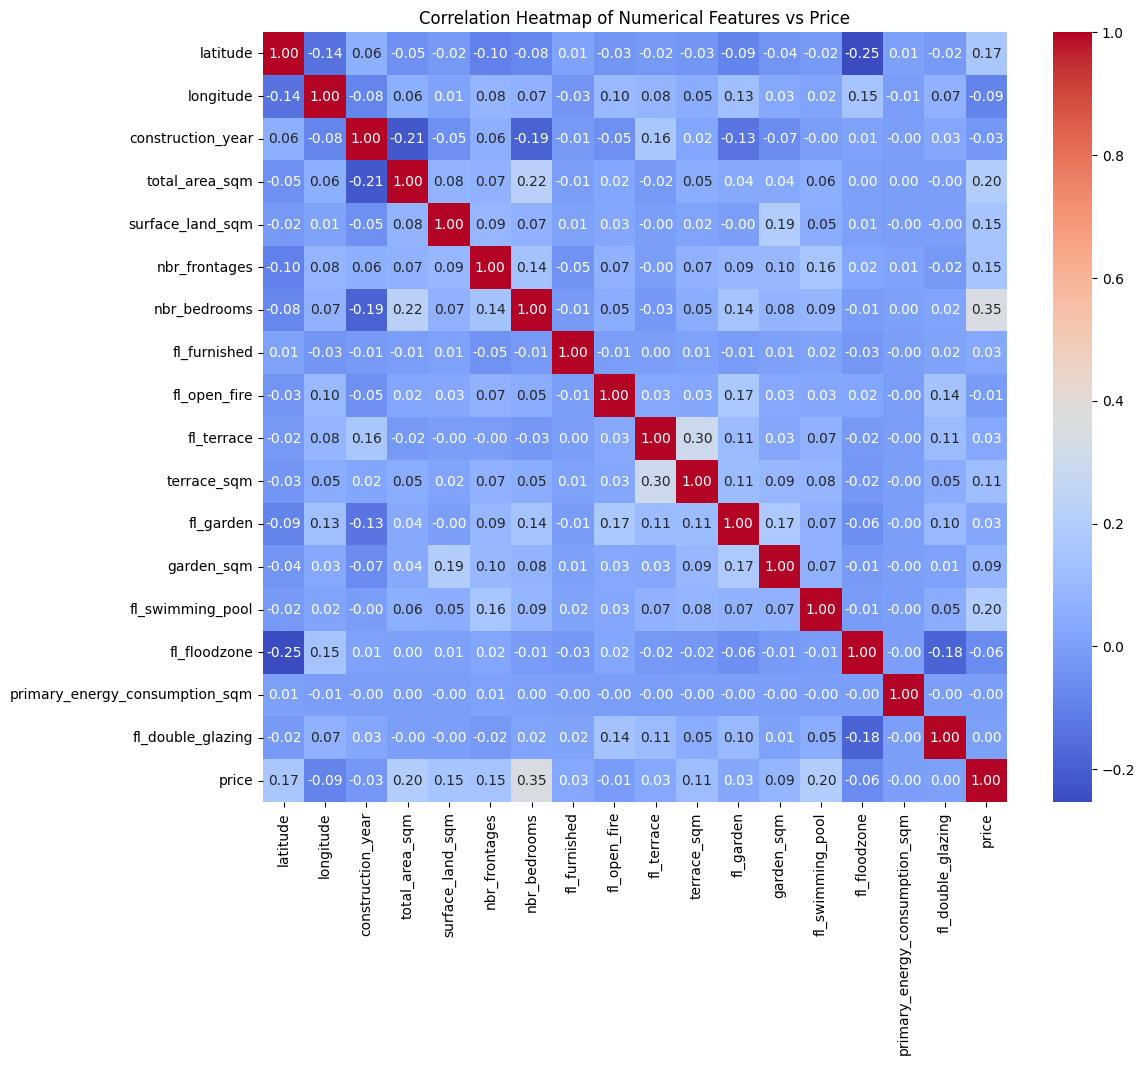

In [328]:
# Compute the correlation matrix
corr = pd.concat([X[numerical_features], y], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of Numerical Features vs Price')
plt.show()


In [329]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=155)

In [330]:
# Create the imputer
imputer = SimpleImputer(strategy='median')

# Select columns with missing values
columns_with_missing_values = X_train.columns[X_train.isnull().any()].tolist()

# Count the number of missing values per column before imputation
missing_values_before = X_train[columns_with_missing_values].isnull().sum()

# Apply the imputer to the selected columns
X_train[columns_with_missing_values] = imputer.fit_transform(X_train[columns_with_missing_values])

# Count the number of missing values per column after imputation
missing_values_after = X_train[columns_with_missing_values].isnull().sum()

# Get the median values for each column
median_values = imputer.statistics_

# Create a DataFrame to display median values and number of imputed values per column
imputation_summary = pd.DataFrame({
    'Column': columns_with_missing_values,
    'Median': median_values,
    'Imputed Values': missing_values_before - missing_values_after
})

# Display the imputation summary
print("Imputation Summary:")
print(imputation_summary)



Imputation Summary:
                                                        Column       Median  \
latitude                                              latitude    50.902228   
longitude                                            longitude     4.377851   
construction_year                            construction_year  1993.000000   
total_area_sqm                                  total_area_sqm   127.000000   
surface_land_sqm                              surface_land_sqm   362.000000   
nbr_frontages                                    nbr_frontages     3.000000   
terrace_sqm                                        terrace_sqm     1.000000   
garden_sqm                                          garden_sqm     0.000000   
primary_energy_consumption_sqm  primary_energy_consumption_sqm   243.000000   

                                Imputed Values  
latitude                                 11264  
longitude                                11264  
construction_year                        2

In [331]:
# Define preprocessing steps for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [332]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer())
])

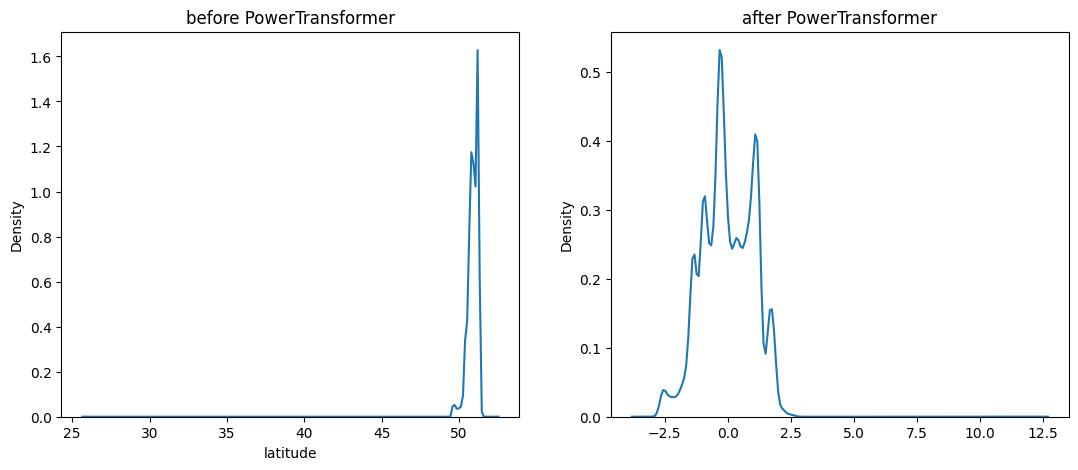

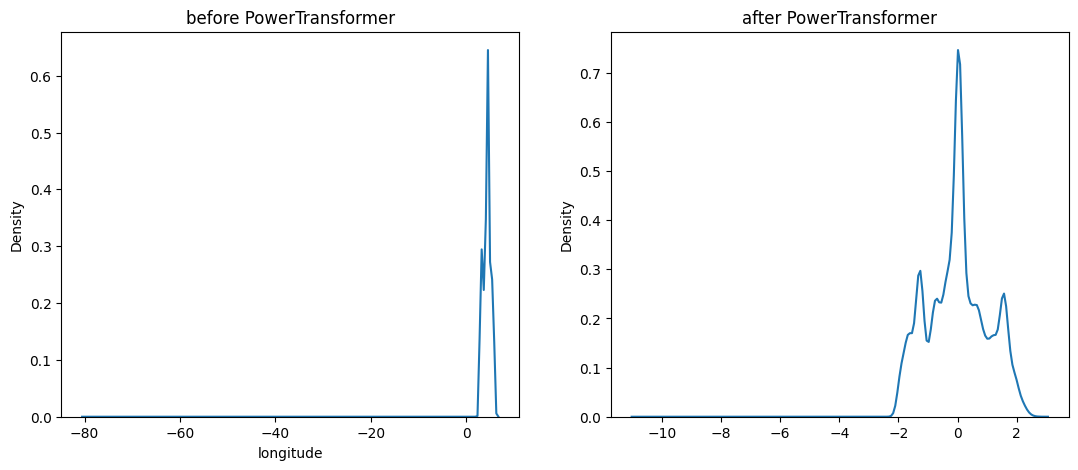

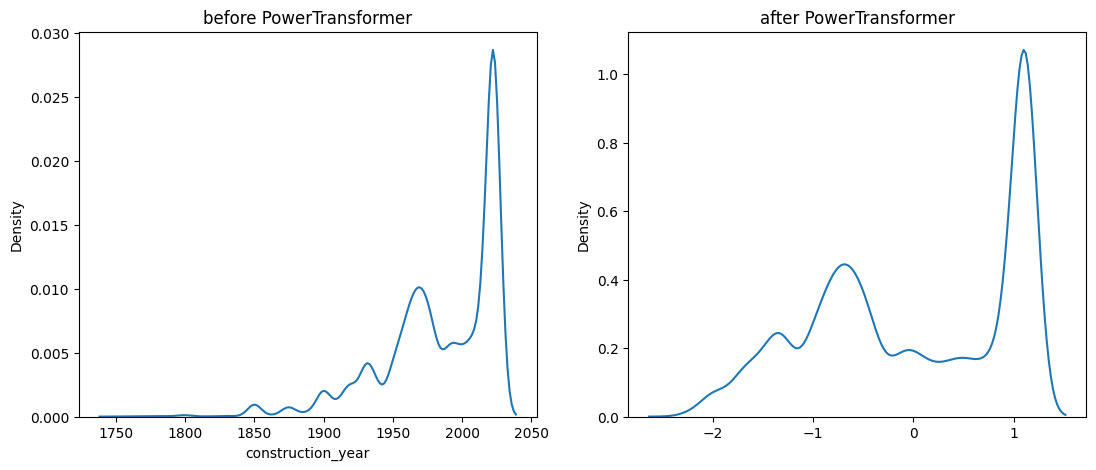

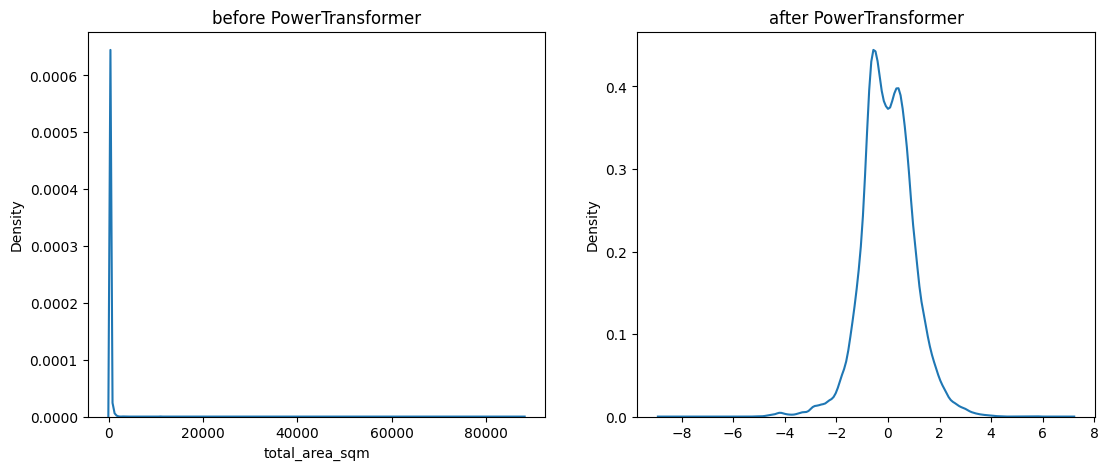

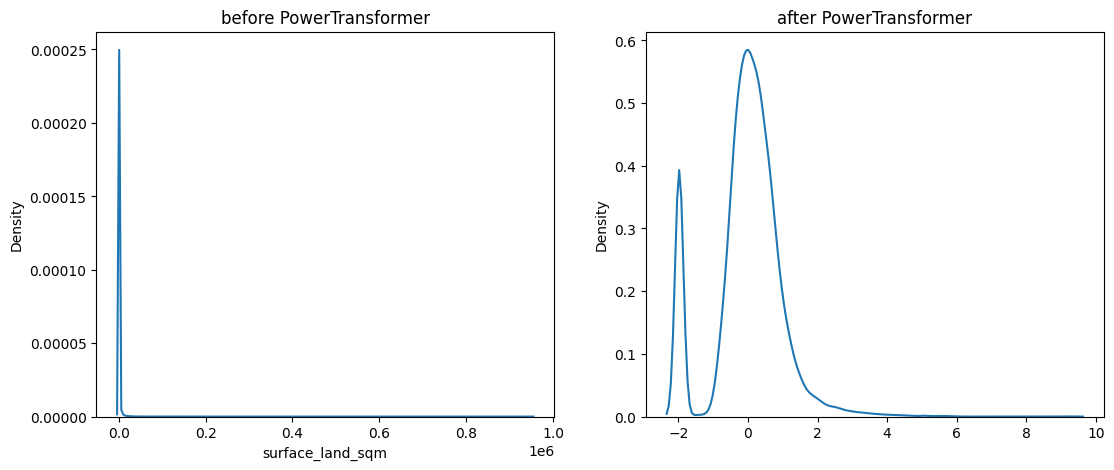

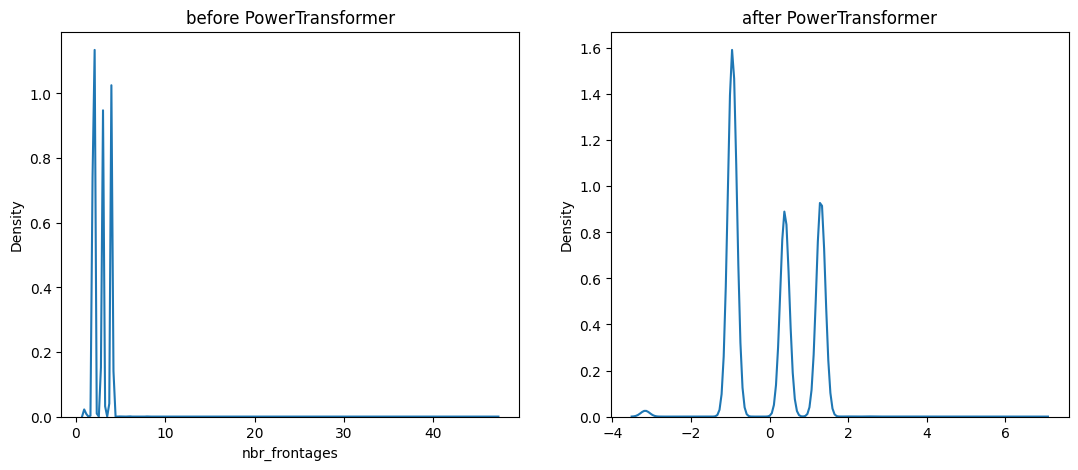

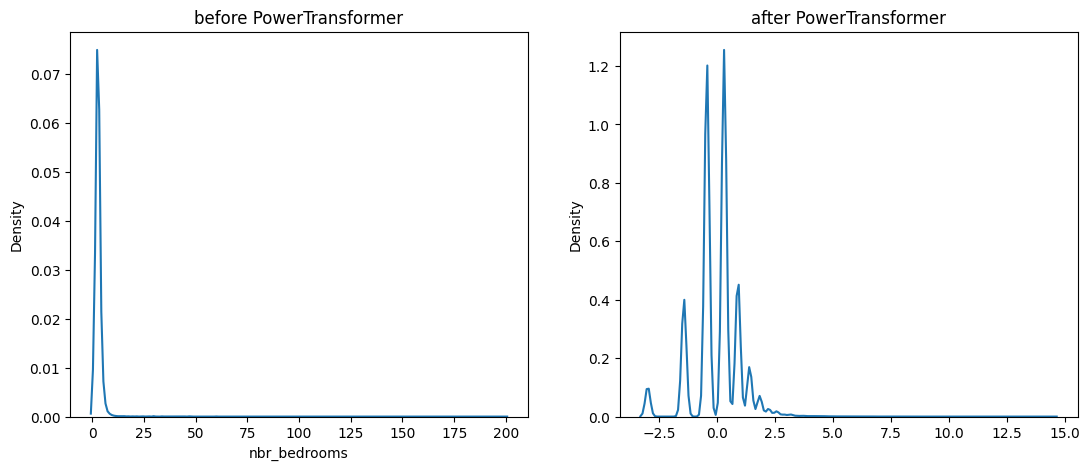

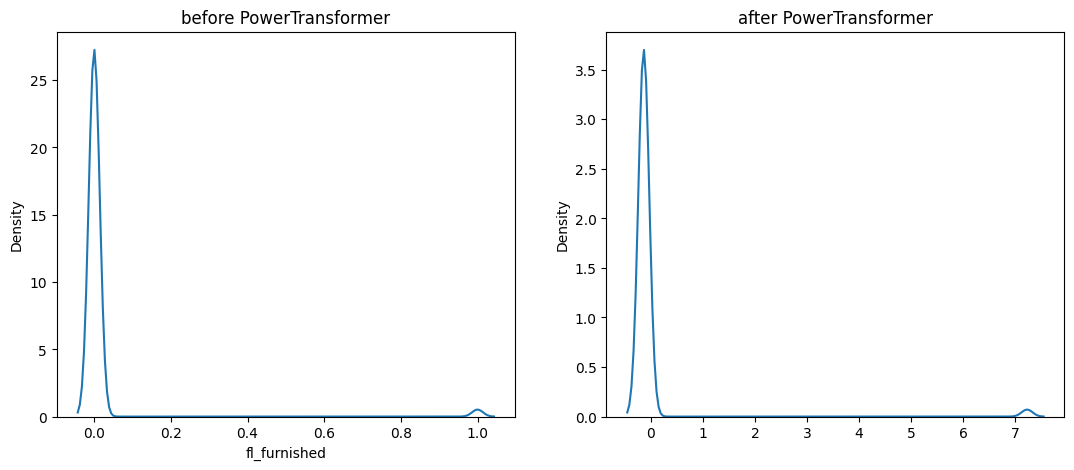

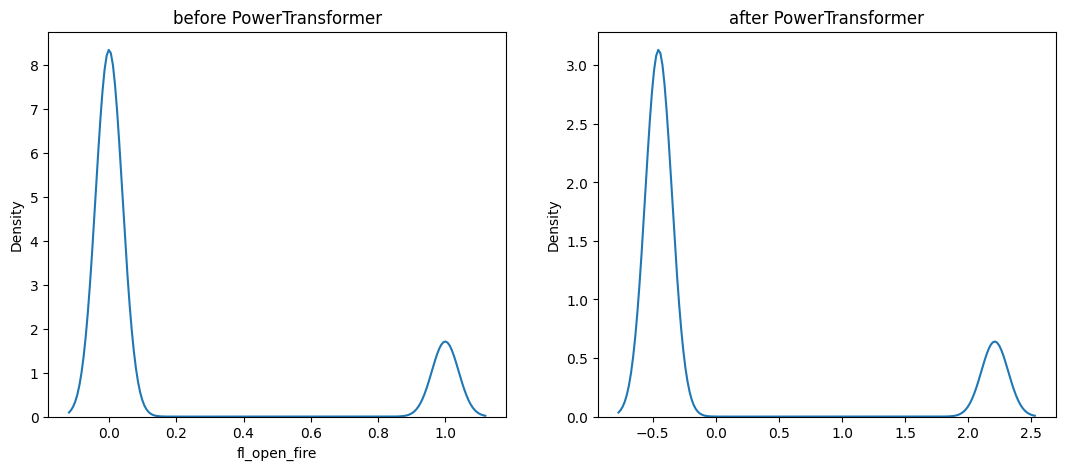

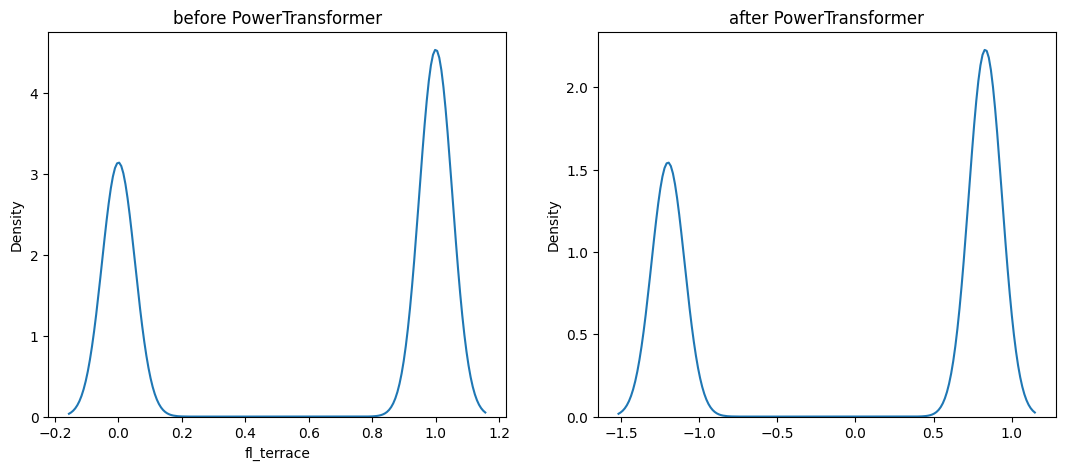

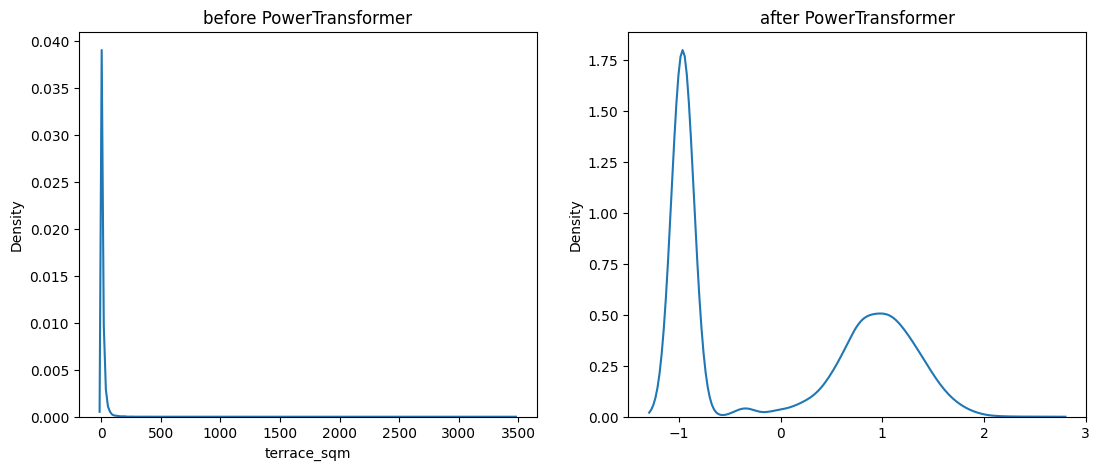

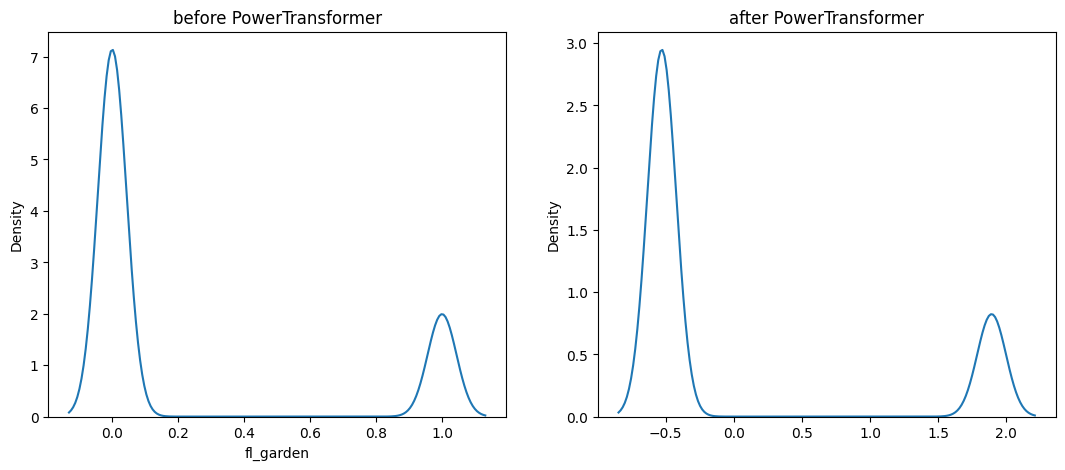

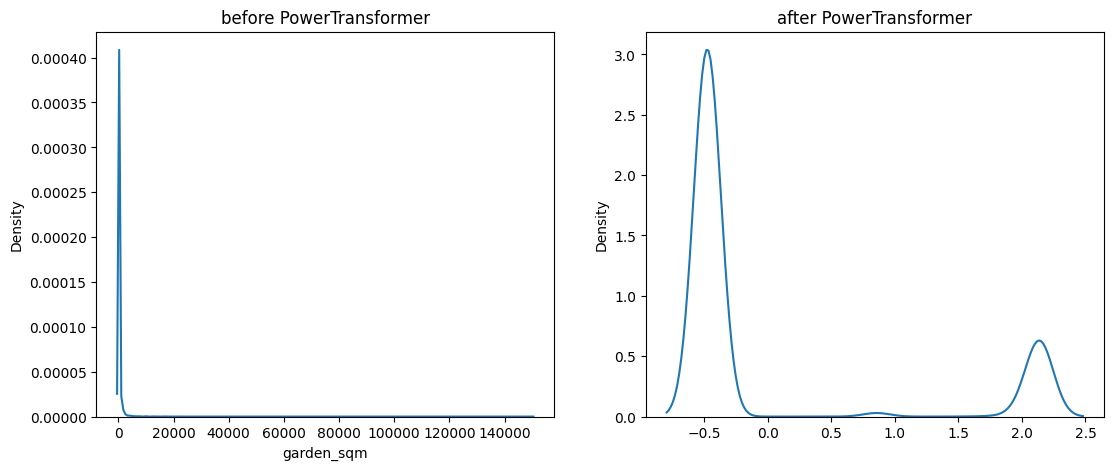

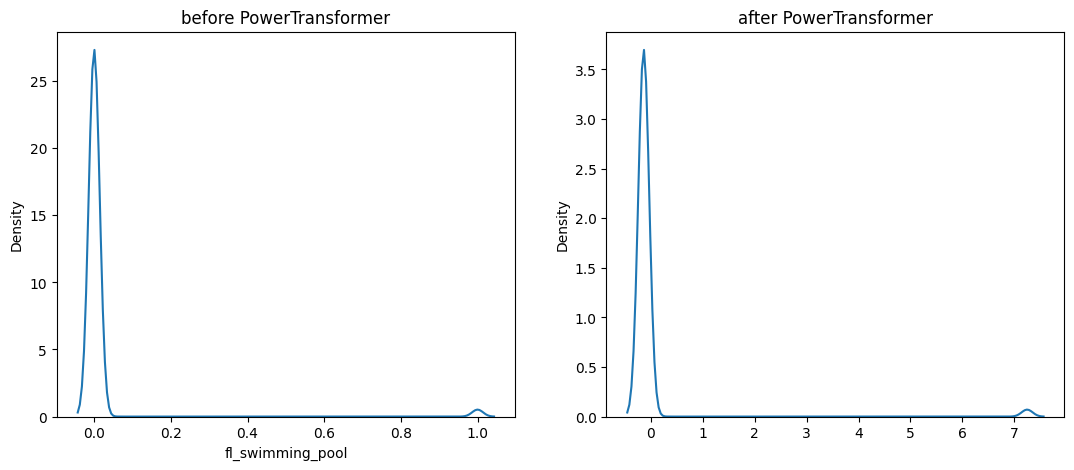

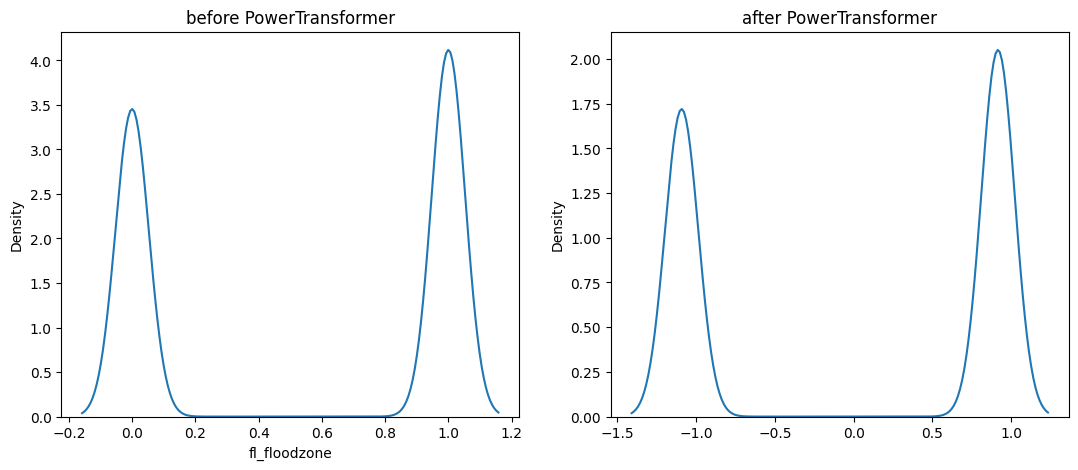

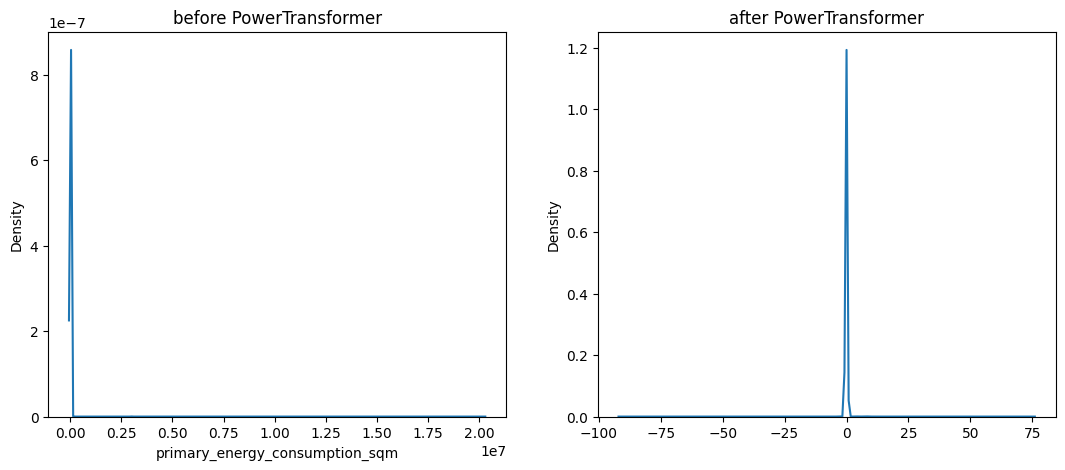

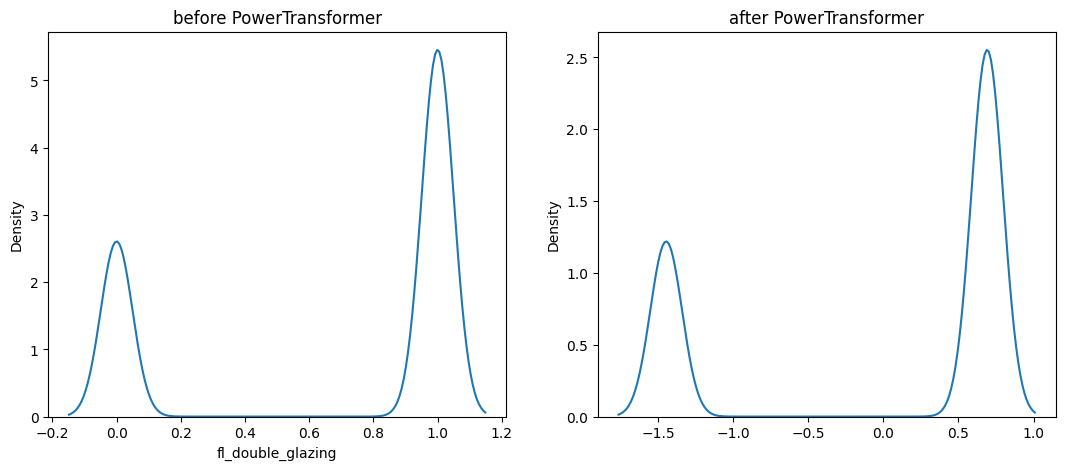

In [333]:
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])

    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])

for col in numerical_features:
    plots(X, col, PowerTransformer())


In [334]:
# Combine preprocessing steps for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

In [335]:
# Define the model
model = LinearRegression()

In [336]:
# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

In [337]:
# Fit the pipeline (preprocessing + model) on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type',
                                                   'subproperty_type',
                                                   'province', 'locality',
                                                   'zip_code',
                                                   'equipped_kitchen',
                                                   'state_building', 'epc',
                                                   'heating_type',
                                                   'postal_zone', 'zi...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['latitude', 'longitude',
                                                   'construction_year',
                                                   'total_area_sqm',
                                                   'surface_land_sqm',
                                                   'nbr_frontages',
                                                   'nbr_bedrooms',
                                                   'fl_furnished',
                                                   'fl_open_fire', 'fl_terrace',
                                                   'terrace_sqm', 'fl_garden',
                                                   'garden_sqm',
                                                   'fl_swimming_pool',
                                                   'fl_floodzone',
                                                   'primary_energy_consumption_sqm',
                                                   'fl_double_glazing'])])),
                ('model', LinearRegression())])

In [338]:
# Make predictions on the testing data
y_pred = pipeline.predict(X_test)

In [339]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Root Mean Squared Error: 292475.3457237516
R-squared: 0.4945987749411891


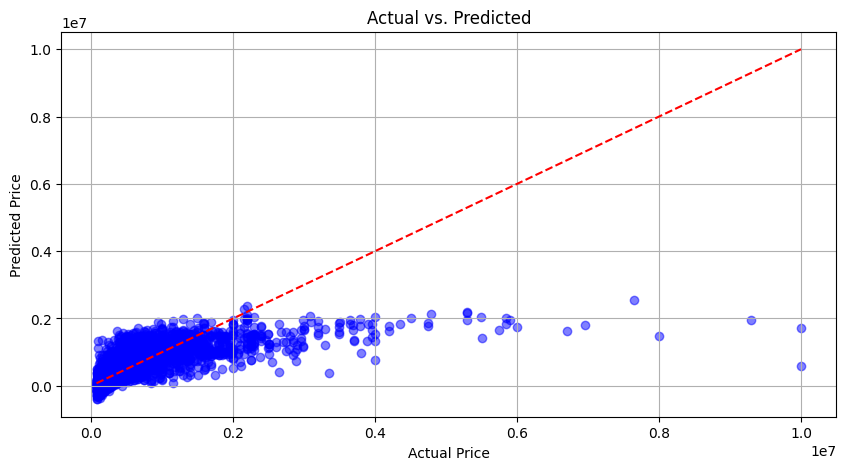

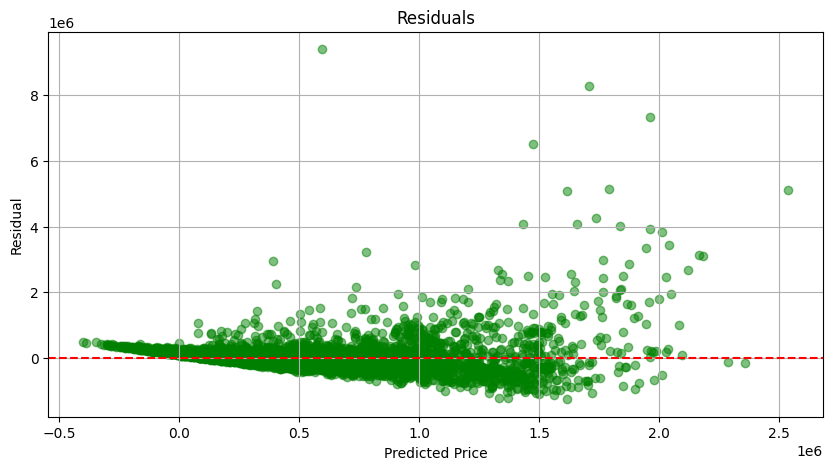

In [343]:
# Calculate residuals
residuals = y_test - y_pred

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

Add cross-validation

In [344]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Root mean square error
rmse_cv_scores = np.sqrt(-cv_scores)

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Print cross-validation results
print("Cross-Validation Root Mean Squared Error:", rmse_cv_scores)
print("Cross-Validation Standard Deviation:", std_cv_score)

# Fit the pipeline (preprocessing + model) on the full dataset
pipeline.fit(X, y)

# Make predictions on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate the model on the testing data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Cross-Validation Root Mean Squared Error: [287775.67472579 284311.28927698 310402.25221261 313503.03464095
 376841.07101873]
Cross-Validation Standard Deviation: 22107611228.161324

Test Set Metrics:
Root Mean Squared Error: 292475.3457237516
R-squared: 0.506795723844395


Final Linear Regression Code

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd


# Load the dataset
df = pd.read_csv('data/properties.csv')

# Define features and target variable
X = df.drop(columns=['id', 'cadastral_income', 'region', 'price'])  # Features
y = df['price']  # Target variable

# New Feature: Extract the first two digits of the zip_code 
X['zip_code'] = X['zip_code'].astype(str)
X['postal_zone'] = X['zip_code'].str[:2]

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist() 
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Define preprocessing steps for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer())
])

# Combine preprocessing steps for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Define the model
model = LinearRegression()

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Fit the pipeline (preprocessing + model) on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# Perform cross-validation
cv_results = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv_scores = np.sqrt(-cv_results)

# Print cross-validation results
print('')
print('Cross-Validation Results:')
print("Cross-Validation Root Mean Squared Error:", rmse_cv_scores.mean())
print("Cross-Validation RMSE Scores:", rmse_cv_scores)
#print("Cross-Validation Standard Deviation:", cv_results.std())



Test Set Metrics:
Root Mean Squared Error: 310885.64486063103
R-squared: 0.492913611089591

Cross-Validation Results:
Cross-Validation Root Mean Squared Error: 314567.2556179407
Cross-Validation RMSE Scores: [287777.76543938 284311.72309405 310400.48152195 313505.34070411
 376840.96733021]


Trying XGBoost

<img src = 'xgboost.png' style='width:580px;height:380px'>


Evaluation Metrics:
Root Mean Squared Error 206199.35514424436
R-squared: 0.7769227813261653

Cross-Validation Results:
Mean Cross-Validation RMSE: 239793.62850024918
Cross-Validation RMSE Scores: [225902.99829091 320352.77117838 256532.37377827 171599.6449082
 224580.35434549]


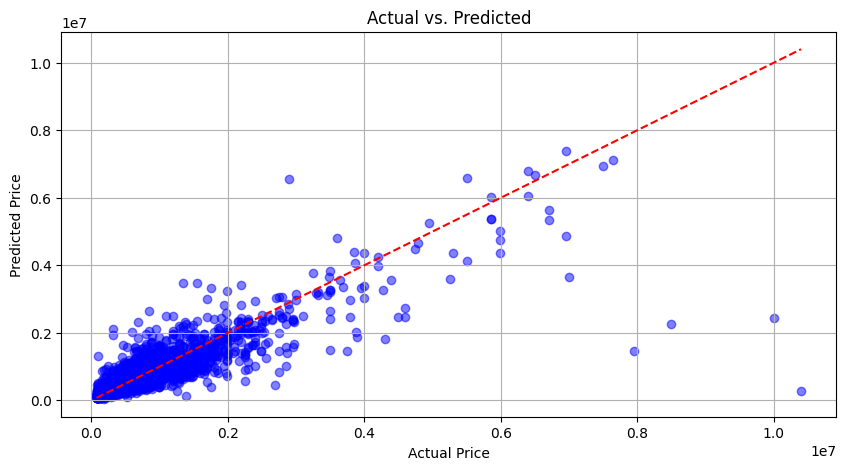

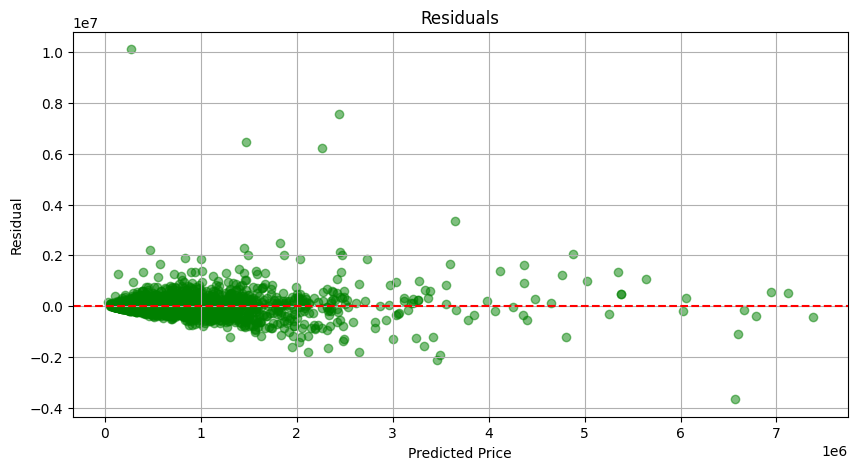

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Constants
DATA_FILE = '../data/properties.csv'
TARGET_COLUMN = 'price'
REMOVE_COLUMN = ['id', 'region', 'cadastral_income']

def load_data(file_path):
    """Load data from CSV file."""
    return pd.read_csv(file_path)

def preprocess_data(df):
    """Preprocess data: handle missing values, encode categorical variables."""
    X = df.drop(columns=[TARGET_COLUMN] + REMOVE_COLUMN)
    y = df[TARGET_COLUMN]
    
    X = pd.get_dummies(X)               # One-hot encoding
    X.fillna(X.median(), inplace=True)  # Fill missing values
    return X, y

def train_model(X_train, y_train):
    """Train XGBoost model."""
    xgb_model = XGBRegressor(
        n_estimators= 200,       # Increase number of trees
        max_depth=8,             # Increase maximum tree depth
        learning_rate=0.1        # Reduce learning rate
    #    subsample=0.8,          # Use subsample of training instances
    #    colsample_bytree        # Use subsample of features
    #    reg_lambda=1,            # L2 regularization
    #    reg_alpha=0.5            # L1 regularization
    )

    xgb_model.fit(X_train, y_train)
    return xgb_model

def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model."""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print evaluation metrics
    print("Evaluation Metrics:")
 #   print("Mean Squared Error:", mse)
    print("Root Mean Squared Error", rmse)
    print("R-squared:", r2)
 #   print("Mean Absolute Error:"," mae)
    
    return y_pred


def perform_cross_validation(model, X_train, y_train):
    """Perform k-fold cross-validation."""
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv_scores = np.sqrt(-cv_scores)
    mean_rmse_cv = rmse_cv_scores.mean()
    print('')
    print('Cross-Validation Results:')
    print("Mean Cross-Validation RMSE:", mean_rmse_cv)
    print("Cross-Validation RMSE Scores:", rmse_cv_scores)    

def plot_results(y_test, y_pred):
    
    # Calculate residuals
    residuals = y_test - y_pred

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.title('Actual vs. Predicted')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.grid(True)
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residuals')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.show()

    
def main():
    # Load data
    df = load_data(DATA_FILE)

    # Preprocess data
    X, y = preprocess_data(df)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    y_pred = evaluate_model(model, X_test, y_test)

    # Perform cross-validation
    perform_cross_validation(model, X_train, y_train)

    # Plot results
    plot_results(y_test, y_pred)


if __name__ == "__main__":
    main()
